# Resolviendo el _Traveling Salesman Problem_ (ANEXO)

Autor: Arnau Garcia Fernandez

En este notebook se programarán las diferentes funciones y el código necesario para resolver el Traveling Salesman Problem en el Final Project de la asignatura de Modelos y Métodos de la Investigación Operativa.

Primeramente definimos la matriz de costes. Hay que tener en cuenta que estamos trabajando con un TSP simétrico.

In [1]:
import numpy as np
bares_time = np.array([
    [0,19,25,21,36,33,37,39,56,35,35,6,17,25],
    [19,0,18,20,32,28,32,36,45,32,32,29,35,39],
    [25,18,0,28,38,33,37,40,50,39,37,36,41,42],
    [21,20,28,0,22,18,23,27,37,24,21,28,18,27],
    [36,32,38,22,0,9,16,22,36,26,15,48,38,34],
    [33,28,33,18,9,0,8,16,28,17,10,44,33,30],
    [37,32,37,23,16,8,0,21,32,22,10,44,33,30],
    [39,36,40,27,22,16,21,0,29,23,24,53,47,42],
    [56,45,50,37,36,28,32,29,0,31,29,63,53,48],
    [35,32,39,24,26,17,22,23,31,0,20,42,32,28],
    [35,32,37,21,15,10,10,24,29,20,0,38,27,25],
    [6,29,36,28,48,44,44,53,63,42,38,0,12,19],
    [17,35,41,18,38,33,33,47,53,32,27,12,0,14],
    [25,39,42,27,34,30,30,42,48,28,25,19,14,0]
])

Definimos una función que dada la matriz de costes y un tour nos calcule el coste de ese tour. Es decir, esta función será usada como función objetivo y será útil durante todo el trabajo.

In [2]:
def cost(mat,tour):
    suma=0
    for i in range(len(tour)-1):
        suma += mat[tour[i],tour[i+1]]
    return(suma)

Ahora vamos a definir una función para implementar el método heurístico de _nearest neighbors_.

In [7]:
def nearest_neighbor(bares_time):
    n = len(bares_time)
    #Inicialmente no hemos visitado ningún bar
    bares_visit = [False] * n
    #Inicializamos tour
    tour = []

    # Elegimos empezar des de Cafés Mateu (donde se produce la salida y la llegada del reparto)
    bar_actual = 0
    tour.append(bar_actual)
    bares_visit[bar_actual] = True

    while(len(tour) < n):
        # Buscamos el bar no visitado más cercano (con menor coste)
        #Fijamos en la matriz la fila del bar actual, recorremos todas las columnas
        #excepto las que sean de bares ya visitados, y nos quedamos con el mínimo.
        nearest_neighbour = min((i for i in range(n) if not bares_visit[i]),
                               key=lambda bar: bares_time[bar_actual][bar])

        # Nos movemos al bar más cercano
        bar_actual = nearest_neighbour
        tour.append(bar_actual)
        bares_visit[bar_actual] = True

    # Acabámos el tour en Cafés mateu 
    tour.append(tour[0])

    return(tour)


result_tour = nearest_neighbor(bares_time)

print("Orden del Tour resultante con Nearest Neihgbors:", result_tour)
print("Coste del Tour resultante con Nearest Neihgbors:", cost(bares_time,result_tour))

Orden del Tour resultante con Nearest Neihgbors: [0, 11, 12, 13, 10, 5, 6, 4, 3, 1, 2, 9, 7, 8, 0]
Coste del Tour resultante con Nearest Neihgbors: 298


Nuestro objetivo ahora es implementar el método de Tabu Search para obtener una mejor solución factible para nuestro STSP. Para entender bien como funciona el método Tabu Search hemos usado las slides de clase y https://riunet.upv.es/handle/10251/167142. Vamos a implementar un tabu search con intercambio del orden de visita de nodos consecutivos en la solución proporcionada por la heurística. Primero, vamos a definir una función que dado un tour y un índice, nos intercambie el orden en que se visitan el nodo del índice dado y el siguiente.

In [8]:
def generador_sol_vecinas(tour,k):
    sol_vecina = tour.copy()
    if(k==len(tour)-2):
        sol_vecina[k]=tour[0]
        sol_vecina[0]=tour[k]
        sol_vecina[len(tour)-1]=sol_vecina[0]
    elif(k==0):
        sol_vecina[k]=tour[k+1]
        sol_vecina[k+1]=tour[k]
        sol_vecina[len(tour)-1]=sol_vecina[k]
    else:
        sol_vecina[k]=tour[k+1]
        sol_vecina[k+1]=tour[k]
    return(sol_vecina)

Definimos nuestra función para implementar Tabu Search. Como argumentos de la función tenemos la solución que nos proporciona la heurística, la matriz de costes, las iteraciones máximas que queremos usar en nuestra implementación de Tabu Search y la tabu "tenure". En esta función lo que haremos será calcular el espacio de soluciones vecinas, crear una lista con las soluciones vecinas que no están en la "tabu list", quedarnos con la mejor solución (la de mínimo coste de la función objetivo), comprobar si está solución es mejor que la que teníamos y si es así, guardarla. La función devuelve la mejor solución encontrada en todo el proceso.

In [9]:
def tabu_search(tour_inicial, mat, iter_max, tabu_tenure):
    sol_actual = tour_inicial.copy()
    best_tour = tour_inicial.copy()
    tabu_list = []
    
    for i in range(iter_max):
        sol_vecina=[]
        sol_vecina_not_tabu=[]
        #Calculamos espacio de sol vecinas, eliminando las que estén en la tabú list
        for j in range(len(sol_actual)-1):
            sol_vecina.append(generador_sol_vecinas(sol_actual,j))
            if(sol_vecina[j] not in tabu_list):
                sol_vecina_not_tabu.append(generador_sol_vecinas(sol_actual,j))
        #Buscamos en el espacio de sol vecinas la de minimo coste
        sol = sol_vecina_not_tabu[0].copy()
        for j in range(len(sol_vecina_not_tabu)):
            if(cost(mat, sol_vecina_not_tabu[j])<cost(mat,sol)):
                sol = sol_vecina_not_tabu[j].copy()
        
        # Como ya sabemos que no va estar en la tabu list, solo comprobamos el move value
        if(cost(mat,sol) < cost(mat, sol_actual)):
            sol_actual = sol.copy()
            tabu_list.append(sol)
            if(len(tabu_list) > tabu_tenure): #eliminamos elementos de la tabu tenure cuando sea necesario
                tabu_list.pop(0)

        # Actualizar mejor sol hallada hasta la fecha
        if(cost(mat, sol_actual) < cost(mat, best_tour)):
            best_tour = sol_actual.copy()

    return(best_tour)

Usamos como tabu tenure 7 (usando lo que vimos en las slides del curso), y pondremos un máximo de 100 iteraciones.

_Observación:_ probamos con diferentes iteraciones máximas, para 1000, 10000 el resultado era el mismo que para 100. Así pues, decidimos dejar como máximas iteraciones 100.

In [10]:
tour_mejorado = tabu_search(result_tour, bares_time, 100, 7)

In [11]:
print("Tour mejorado:", tour_mejorado)
print("Coste del tour mejorado:", cost(bares_time, tour_mejorado))

Tour mejorado: [0, 11, 12, 13, 10, 6, 5, 4, 3, 1, 2, 9, 8, 7, 0]
Coste del tour mejorado: 282


### Visualización de grafos
Usaremos una librería de python muy útil, `networkx`, para imprimir grafos. La usaremos para imprimir los grafos correspondientes a las soluciones que vayamos encontrando durante el trabajo.

Primeramente definimos una función que dada una matriz de costes simétrica nos contruya un grafo completo usando los costes en dicha matriz.

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
def grafo(cost_matrix):
    num_nodes = len(cost_matrix)

    # Create a complete graph (all nodes connected to all nodes)
    G = nx.complete_graph(num_nodes)

    # Add weights to the edges based on the distance matrix
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            weight = cost_matrix[i, j]
            G[i][j]['weight'] = weight
            G[j][i]['weight'] = weight

    return G

A continuación, construimos un grafo completo con todos los tiempos entre bares usando la función `grafo` y imorimimos el grafo usando `matplotlib`. 

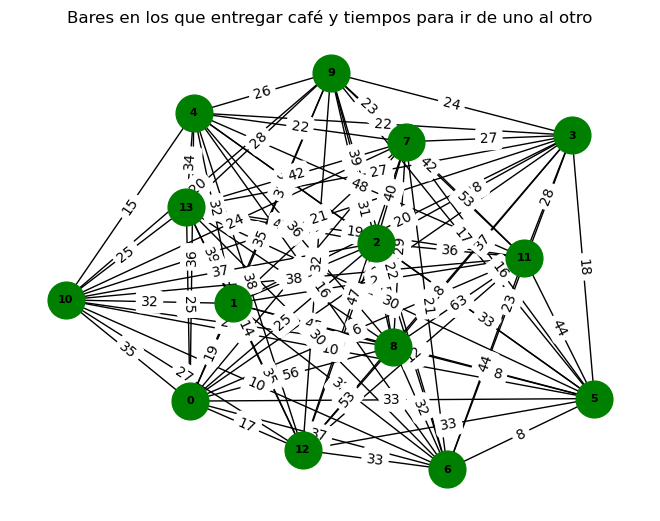

In [9]:
# Construimos el grafo 
weighted_graph = grafo(bares_time)

# imprimimos
pos = nx.spring_layout(weighted_graph)  
nx.draw(weighted_graph, pos, with_labels=True, node_size=700, node_color="green", 
        font_size=8, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(weighted_graph, 'weight')
nx.draw_networkx_edge_labels(weighted_graph, pos, edge_labels=labels)
plt.title("Bares en los que entregar café y tiempos para ir de uno al otro")
plt.show()

Ahora, definimos una función que dada una matriz de costes y una tour que sea solución del problema nos devuelva la matriz de costes asociada a la solución. Lo que haremos será inicializar a 0 la matriz y llenar las componentes de la matriz correspondientes a los nodos conectados por la solución.

In [14]:
def new_matrix(mat, sol):
    new_mat = np.zeros((len(sol)-1,len(sol)-1), dtype=int)
    for i in range(len(sol)-1):
        new_mat[sol[i],sol[i+1]]= int(mat[sol[i],sol[i+1]])
        new_mat[sol[i+1],sol[i]]= int(mat[sol[i+1],sol[i]])
    return(new_mat)

Usando esta función `new_matrix`, imprimimos los grafos correspondientes a las soluciones que obtenemos. Lo que haremos serà programar el código de forma que aquellas aristas con peso igual a 0 no se impriman, así podremos ver un grafo más claro con solo las aristas que conectan los nodos en el tour.

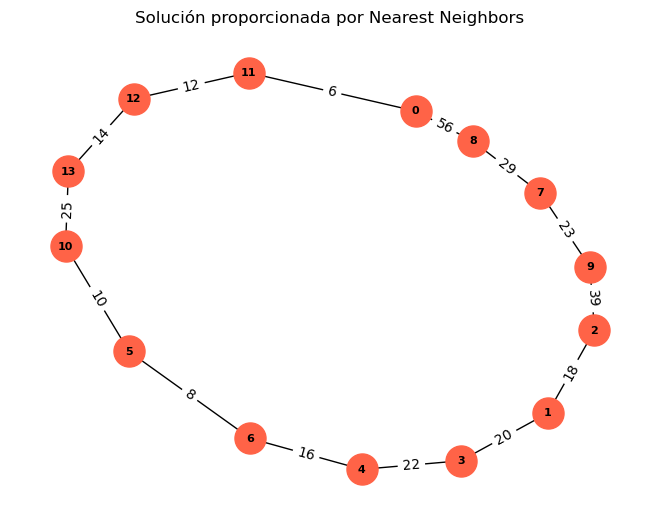

In [20]:
#Matriz de tiempos para la sol de NN
bares_sol1 = new_matrix(bares_time, result_tour)

weighted_graph = grafo(bares_sol1)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight'] > 0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph)  
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="tomato", 
        font_size=8, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución proporcionada por Nearest Neighbors")
plt.show()

Volvemos a hacer lo mismo, esta vez para imprimir el grafo correspondiente a la solución mejorada con Tabu Search.

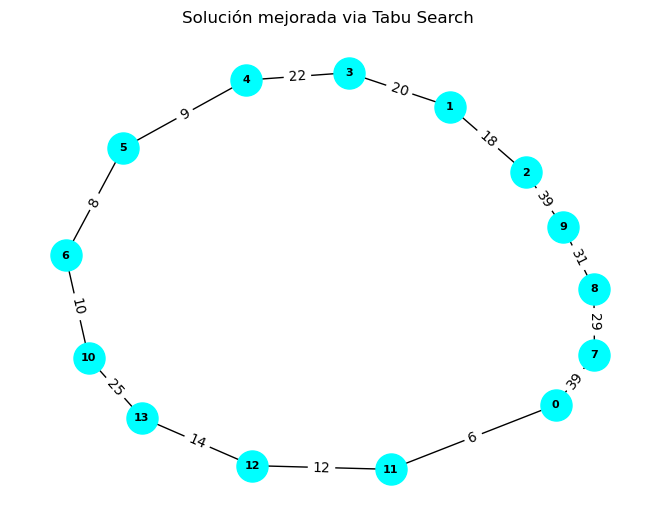

In [21]:
#Matriz de distancias para sol de tabu search
bares_sol2=new_matrix(bares_time, tour_mejorado)

weighted_graph = grafo(bares_sol2)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight'] > 0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph)  
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="cyan", 
        font_size=8, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución mejorada via Tabu Search ")
plt.show()

Lo que haremos ahora es representar los grafos correspondientes a las soluciones de las relajaciones lineales. Para ello, definiremos las matrices que nos devuelve AMPL al resolver la relajación manualmente. Una vez tenemos la matriz de costes, definimos el grafo y lo imprimimos. Con estos grafos podremos usar algoritmos de separación más fácilmente, y podremos observar de forma visual el comportamiento de nuestras soluciones.

In [22]:
lr = np.zeros((14,14), dtype=int)
lr[11,0], lr[0,11]=1,1
lr[2,1],lr[1,2]=1,1
lr[1,2],lr[2,1]=1,1
lr[9,3],lr[3,9]=1,1
lr[5,4],lr[4,5]=1,1
lr[10,6],lr[6,10]=1,1
lr[8,7],lr[7,8]=1,1 
lr[13,12], lr[12,13]=1,1

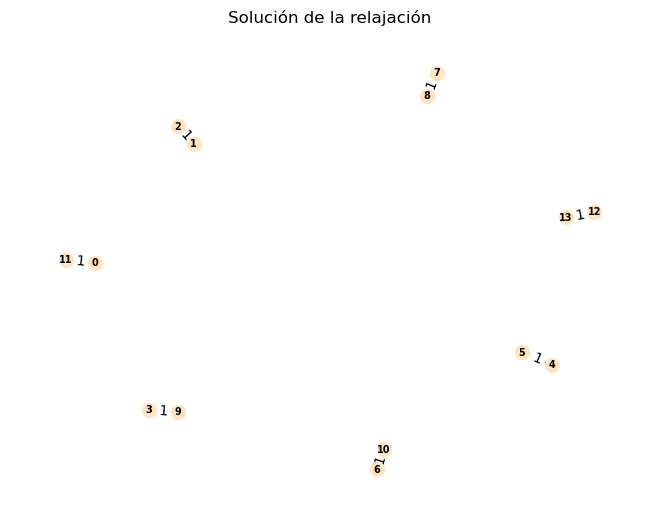

In [23]:
weighted_graph = grafo(lr)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight'] > 0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="bisque", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación")
plt.show()

AMPL nos devuelve como solución el grafo que acabamos de ver en el chunk anterior. El coste de esta solución es de 220. Recordemos que el coste con NN era de 298 y el coste del tour mejorado con Tabu Search era de 282. Como esperábamos, el coste de la relajación lineal es mejor que el de los métodos heurísricos. El coste de la relajación lineal nos servirá como cota inferior de la solución óptima del problema. Los costes proporcionados por las heurísticas nos servirán como cotas superiores.

Si nos fijamos, podemos ver que vía Relajación Lineal y quitando las SEC, son todo subtours de pares de nodos. De esta forma, los pares de nodos que se encuetran emparejados son subconjuntos de nodos que violan una SEC. Así pues, los subconjuntos de nodos que violan SEC son:
- {0,11}
- {1,2}
- {8,7}
- {4,5}
- {3,9}
- {6,10}
- {12,13}

Después de resolver la nueva relajación lineal con las SEC violadas añadidas obtenemos una nueva solución con AMPL. Lo que hacemos a continuación es dibujar el grafo correspondiente a la nueva solución, de la misma forma que hemos hecho anteriormente.


In [24]:
lr_sec1 = np.zeros((14,14), dtype=int)
lr_sec1[11,0],lr_sec1[0,11]=1,1
lr_sec1[2,1],lr_sec1[1,2]=1,1
lr_sec1[0,2],lr_sec1[2,0]=1,1
lr_sec1[1,3],lr_sec1[3,1]=1,1
lr_sec1[5,4],lr_sec1[4,5]=1,1
lr_sec1[6,5], lr_sec1[5,6]=1,1
lr_sec1[10,6], lr_sec1[6,10]=1,1
lr_sec1[9,7],lr_sec1[7,9]=1,1 
lr_sec1[7,8], lr_sec1[8,7]=1,1
lr_sec1[8,9], lr_sec1[9,8]=1,1
lr_sec1[4,10], lr_sec1[10,4]=1,1
lr_sec1[13,11], lr_sec1[11,13]=1,1
lr_sec1[3,12],lr_sec1[12,3]=1,1
lr_sec1[12,13], lr_sec1[13,12]=1,1 

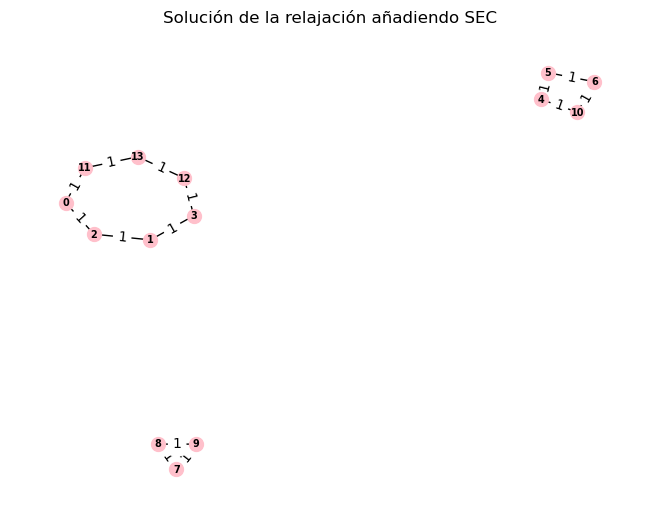

In [16]:
weighted_graph = grafo(lr_sec1)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight'] > 0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="pink", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo SEC")
plt.show()

El coste de esta solución es de 245.

Podemos ver fácilmente que los siguientes subconjuntos de nodos violan SEC (tomamos nodos 1,2,..,14):
- {11,0,2,1,3,12,13}
- {9,7,8}
- {10,4,5,6}

Añadimos estos subconjuntos de nodos que sabemos que violan SECs a nuestra relajación lineal y obtenemos una nueva solución. De nuevo, representamos el grafo asociado a esta nueva solución.

In [25]:
lr_sec2 = np.zeros((14,14), dtype=int)
lr_sec2[11,0],lr_sec2[0,11]= 1,1
lr_sec2[2,1], lr_sec2[1,2]=1,1
lr_sec2[0,2], lr_sec2[2,0]=1,1
lr_sec2[1,3], lr_sec2[3,1] =1,1
lr_sec2[5,4], lr_sec2[4,5]=1,1
lr_sec2[6,5], lr_sec2[5,6]=1,1
lr_sec2[10,6], lr_sec2[6,10]=1,1
lr_sec2[4,7], lr_sec2[7,4]=1,1
lr_sec2[7,8], lr_sec2[8,7]=1,1
lr_sec2[8,9], lr_sec2[9,8]=1,1
lr_sec2[3,10], lr_sec2[10,3]=1,1
lr_sec2[12,11], lr_sec2[11,12]=1,1
lr_sec2[13,12], lr_sec2[12,13]=1,1
lr_sec2[9,13], lr_sec2[13,9]=1,1

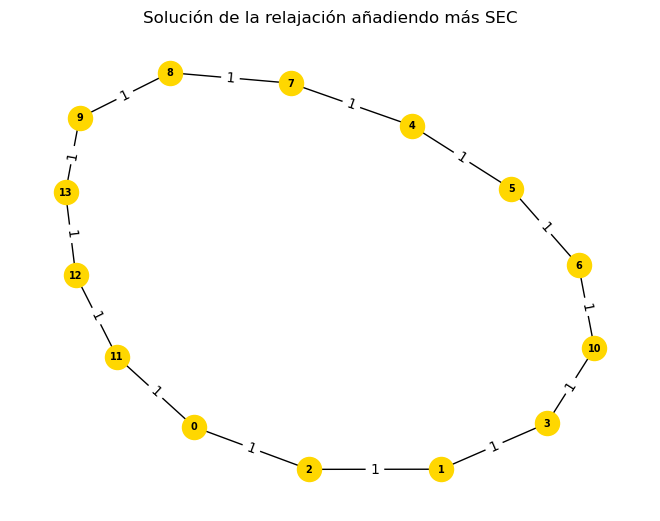

In [18]:
weighted_graph = grafo(lr_sec2)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight'] > 0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color="gold", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo más SEC")
plt.show()

Es una solución entera que no presenta subtours! Así pues hemos hallado la solución óptima de nuestro problema TSP. Si observamos los resultados que nos ha devuelto ampl vemos que esta solución tiene un coste de 253. Recordemos que la solución de la relajación lineal sin imponer las SEC que sabemos que no se satisfacen es de 220.

Dibujamos ahora el grafo con los costes correspondientes.

In [26]:
optim_tour = [0,11,12,13,9,8,7,4,5,6,10,3,1,2,0]

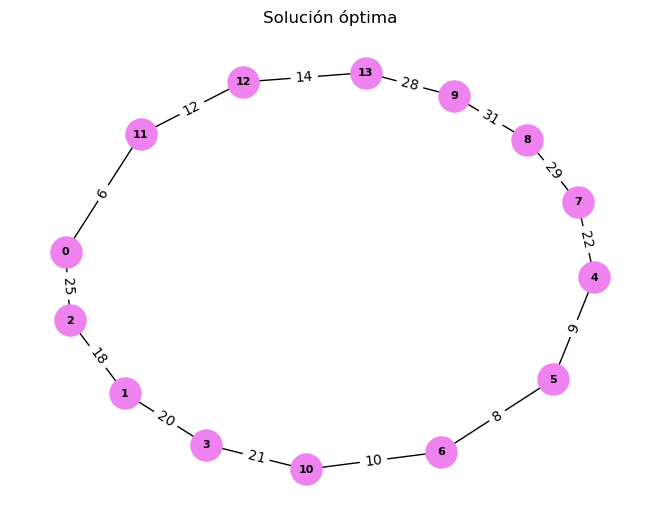

In [28]:
#Matriz de distancias para sol de tabu search
bares_optim=new_matrix(bares_time, optim_tour)

weighted_graph = grafo(bares_optim)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight'] > 0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph)  
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="violet", 
        font_size=8, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución óptima")
plt.show()

Comprobamos que el coste es de 253 tal y como nos indica AMPL.

In [21]:
cost(bares_time, optim_tour)

253

## Explorando un poco más allá

En la parte que sigue vemos otras formas de explorar la solución de nuestro TSP. Lo que vamos a hacer será la siguiente exploración, resolviendo las relajaciones lineales con el solver AMPL-Gurobi. 

- Primero resolvemos la relajación lineal inicial, obteniendo la solución con siete pares de subtours que hemos impreso anteriormente en este notebook. A pesar de que podemos ver a simple vista todas las SEC violada sin necesidad de usar un algoritmo de separación, solo vamos a añadir uno de los subconjuntos de nodos que viola la SEC.
- Añadimos la SEC violada por el subconjunto $W=\{1,2\}$.
- Añadimos la SEC violada por el subconjunto $W_1=\{4,5\}$.
- Añadimos la SEC violada por el subconjunto $W_2=\{12,13\}$.
- Añadimos la SEC violada por el subconjunto $W_3=\{10,4,5,6\}$.
- Añadimos la _2-match inequality_ definida por los subconjubtos $H=\{4,5,6\}$, $T_1=\{4,7\}, T_2=\{5,9\},T_3=\{6,10\}$.
- Añadimos la _comb inequality_ definida por los subconjubtos $H=\{5,6,7\}$, $T_1=\{6,10\}, T_2=\{4,5\},T_3=\{7,8,9\}$.

Lo que vamos a hacer en este notebook es definir las matrices solución que nos devuelve el solver AMPL-Gurobi y representar los respectivos grafos para cada uno de los pasos. Estos grafos servirán para ver como se comportan las soluciones.

Empezamos definiendo la matriz que nos devuelve el solver después de añadir la primera SEC (con $W=\{1,2\}$) y representando el grafo correspondiente.

In [22]:
mat1 = np.zeros((14,14))
mat1[0,11],mat1[11,0]=1,1
mat1[1,2],mat1[2,1]=1,1
mat1[2,3],mat1[3,2]=1,1
mat1[3,1],mat1[1,3]=1,1
mat1[4,5],mat1[5,4]=1,1
mat1[5,4],mat1[4,5]=1,1
mat1[6,10],mat1[10,6]=1,1
mat1[7,9],mat1[9,7]=1,1
mat1[8,7],mat1[7,8]=1,1
mat1[9,8],mat1[8,9]=1,1
mat1[10,6],mat1[6,10]=1,1
mat1[0,11],mat1[11,0]=1,1
mat1[12,13],mat1[13,12]=1,1
mat1[12,13],mat1[13,12]=1,1

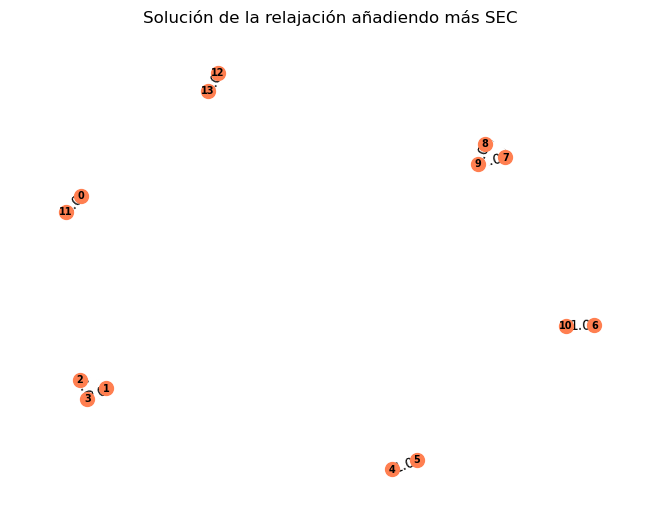

In [23]:
weighted_graph = grafo(mat1)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight']>0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="coral", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo más SEC")
plt.show()

El coste de esta solución es de $227$ (el coste de la primera relajación era de $220$). Claramente vemos diferentes SEC que se violan. No obstante solo añadimos la SEC violada por el subconjunto $W_1=\{4,5\}$. Resolvemos la relajación con AMPL-Gurobi. Definimos la matriz solución que nos devuelve AMPL.

In [24]:
mat2 = np.zeros((14,14))
mat2[0,11],mat2[11,0]=1,1
mat2[1,2],mat2[2,1]=1,1
mat2[2,3],mat2[3,2]=1,1
mat2[3,1],mat2[1,3]=1,1
mat2[4,10],mat2[10,4]=1,1
mat2[5,4],mat2[4,5]=1,1
mat2[6,5],mat2[5,6]=1,1
mat2[7,9],mat2[9,7]=1,1
mat2[8,7],mat2[7,8]=1,1
mat2[9,8],mat2[8,9]=1,1
mat2[10,6],mat2[6,10]=1,1
mat2[11,0],mat2[0,11]=1,1
mat2[12,13],mat2[13,12]=1,1
mat2[13,12],mat2[12,13]=1,1

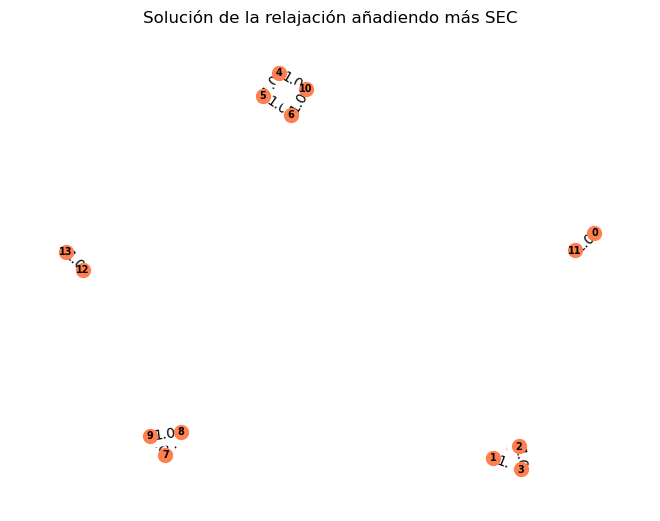

In [25]:
weighted_graph = grafo(mat2)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight']>0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="coral", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo más SEC")
plt.show()

Esta solución es de coste $231$. Añadimos la SEC violada por el subconjunto de nodos $W_2=\{12,13\}$. Definimos la matriz de la solución que nos devuelve AMPL.

In [50]:
mat3 = np.zeros((14,14))
mat3[0,11],mat3[11,0]=1.5,1.5
mat3[1,2],mat3[2,1]=1,1
mat3[1,3],mat3[3,1]=1,1
mat3[2,0],mat3[0,2]=0.5,0.5
mat3[3,2],mat3[2,3]=0.5,0.5
mat3[4,10],mat3[10,4]=1,1
mat3[5,4],mat3[4,5]=1,1
mat3[6,5],mat3[5,6]=1,1
mat3[7,8],mat3[8,7]=1.5,1.5
mat3[7,9],mat3[9,7]=0.5,0.5
mat3[9,8],mat3[8,9]=0.5,0.5
mat3[9,13],mat3[13,9]=1,1
mat3[10,6],mat3[6,10]=1,1
mat3[11,12],mat3[12,11]=0.5,0.5
mat3[12,3],mat3[3,12]=0.5,0.5
mat3[12,13],mat3[13,12]=1,1

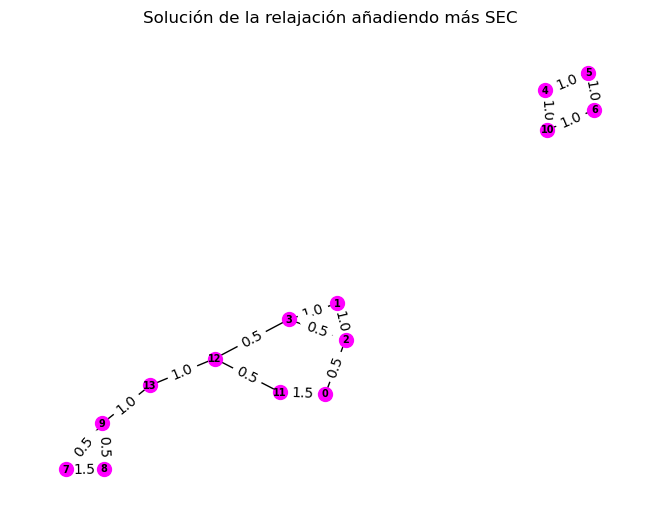

In [55]:
weighted_graph = grafo(mat3)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight']>0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="fuchsia", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo más SEC")
plt.show()

Esta solución tiene un coste de $243$. Vemos que claramente el subconjunto $W_3=\{10,4,5,6\}$, añadimos pues la SEC violada por este subconjunto, resolvemos la relajación lineal y definimos la matriz solución que nos devuelve el solver.

Podemos observar que esta solución anterior es no entera, es la primera solución no entera que hemos obtenido. Además, se puede ver que hay nodos que están conectados por pesos mayores que uno, estos nodos son $\{0,11\}$, $\{7,8\}$. Usando el algoritmo de separación heurístico visto en clase, sabemos que estos subconjuntos de nodos violan una SEC. Esto tiene todo el sentido, pues los dos pares de nodos $\{0,11\}$, $\{7,8\}$, son de los que al inicio violaban una SEC, por lo tanto tienen que seguir incumpliendo la restricción.

In [56]:
mat4=np.zeros((14,14))
mat4[0,11],mat4[11,0]=1.5,1.5
mat4[1,2],mat4[2,1]=1,1
mat4[2,0],mat4[0,2]=0.5,0.5
mat4[2,3],mat4[3,2]=0.5,0.5
mat4[3,1],mat4[1,3]=1,1
mat4[4,5],mat4[5,4]=1,1
mat4[4,7],mat4[7,4]=1,1
mat4[5,6],mat4[6,5]=0.5,0.5
mat4[6,10],mat4[10,6]=1.5,1.5
mat4[7,8],mat4[8,7]=1,1
mat4[8,9],mat4[9,8]=1,1
mat4[9,5],mat4[5,9]=0.5,0.5
mat4[10,13],mat4[13,10]=0.5,0.5
mat4[11,12],mat4[12,11]=0.5,0.5
mat4[12,3],mat4[3,12]=0.5,0.5
mat4[12,13],mat4[13,12]=1,1
mat4[13,9],mat4[9,13]=0.5,0.5

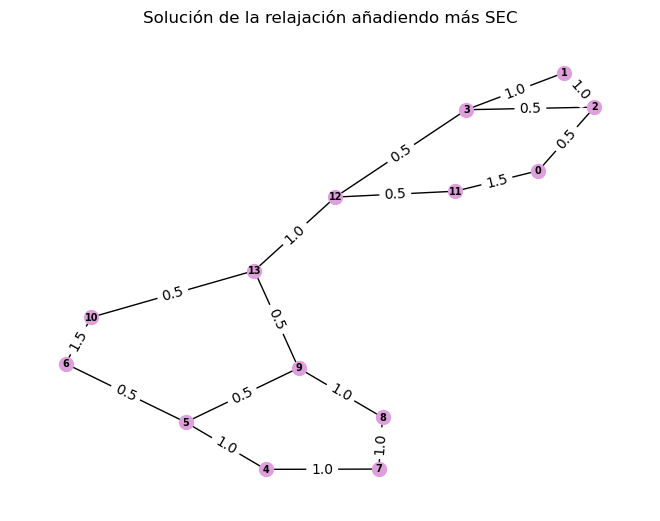

In [58]:
weighted_graph = grafo(mat4)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight']>0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="plum", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo más SEC")
plt.show()

El coste de esta solución es de $247.5$. El lector puede observar que ahora no se ven subconjuntos que no satisfacen las SEC a simple vista. Lo que haremos ahora es añadir la 2-match inequality violada por los subconjuntos $H=\{4,5,6\}$, $T_1=\{4,7\}, T_2=\{5,9\},T_3=\{6,10\}$.

In [59]:
mat5=np.zeros((14,14))
mat5[0,11],mat5[11,0]=1.5,1.5
mat5[1,2],mat5[2,1]=1,1
mat5[2,0],mat5[0,2]=0.5,0.5
mat5[2,3],mat5[3,2]=0.5,0.5
mat5[3,1],mat5[1,3]=1,1
mat5[4,5],mat5[5,4]=1,1
mat5[4,7],mat5[7,4]=1,1
mat5[5,6],mat5[6,5]=0.5,0.5
mat5[6,10],mat5[10,6]=1.5,1.5
mat5[7,5],mat5[5,7]=0.5,0.5
mat5[8,7],mat5[7,8]=0.5,0.5
mat5[9,8],mat5[8,9]=1.5,1.5
mat5[10,13],mat5[13,10]=0.5,0.5
mat5[11,12],mat5[12,11]=0.5,0.5
mat5[12,3],mat5[3,12]=0.5,0.5
mat5[12,13],mat5[13,12]=1,1
mat5[13,9],mat5[9,13]=0.5,0.5

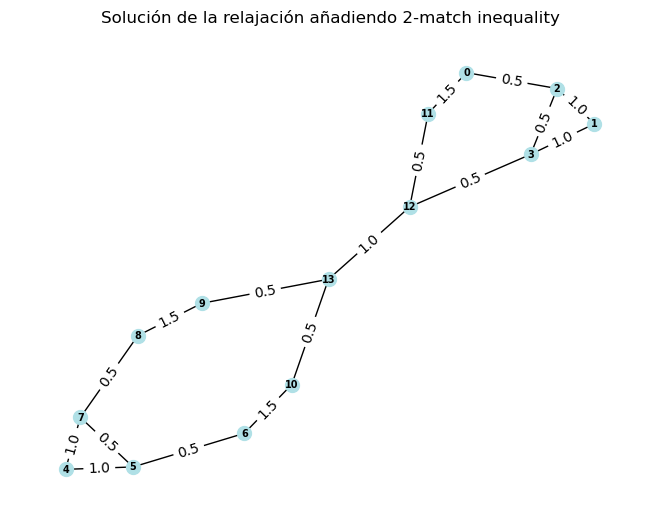

In [60]:
weighted_graph = grafo(mat5)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight']>0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="powderblue", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo 2-match inequality")
plt.show()

El coste de esta solución es de $248$. Añadimos la comb inequality violada por los subconjuntos $H=\{6,5,7\}$, $T_1=\{6,10\}, T_2=\{5,4\},T_3=\{7,8,9\}$. 

In [61]:
mat6=np.zeros((14,14))
mat6[0,11],mat6[11,0]=1.5,1.5
mat6[1,2],mat6[2,1]=1,1
mat6[2,0],mat6[0,2]=0.5,0.5
mat6[2,3],mat6[3,2]=0.5,0.5
mat6[3,1],mat6[1,3]=1,1
mat6[4,5],mat6[5,4]=1,1
mat6[5,6],mat6[6,5]=1,1
mat6[6,10],mat6[10,6]=1,1
mat6[7,4],mat6[4,7]=1,1
mat6[8,7],mat6[7,8]=1,1
mat6[9,8],mat6[8,9]=1,1
mat6[10,9],mat6[9,10]=0.5,0.5
mat6[10,13],mat6[13,10]=0.5,0.5
mat6[11,12],mat6[12,11]=0.5,0.5
mat6[12,3],mat6[3,12]=0.5,0.5
mat6[12,13],mat6[13,12]=1,1
mat6[13,9],mat6[9,13]=0.5,0.5

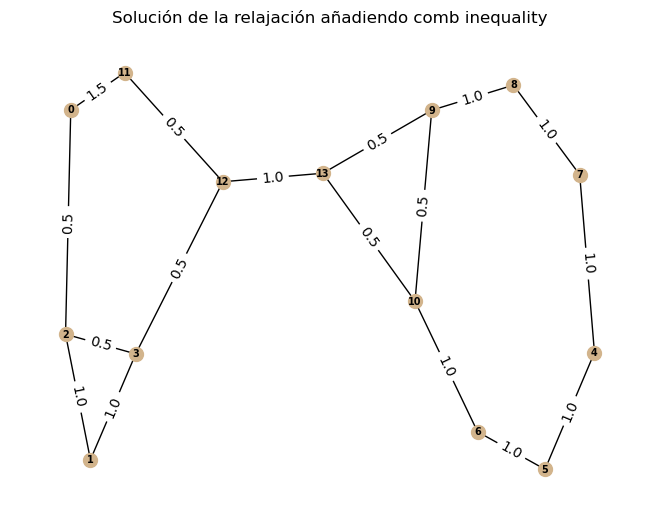

In [62]:
weighted_graph = grafo(mat6)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight']>0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="tan", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo comb inequality")
plt.show()

El coste de esta solución es de nuevo $248$, pero podemos ver que obtenemos más soluciones enteras que en el paso anterior. Usamos ahora un algortimo de separación, usamos manualmente el método de separación heurístico visto en clase, y vemos rápidamente que el subconjunto de nodos $W_4=\{1,2,3\}$ viola una SEC. Y también el subconjunto $W_5=\{0,11\}$ y el $W_6=\{10,6,5,4,7,8,9\}$  Añadimos las correspondientes SEC a nuestro problema y resolvemos la relajación lineal usando AMPL. Definimos a continuación la matriz solución que obtenemos.

In [32]:
mat7=np.zeros((14,14))
mat7[0,11],mat7[11,0]=1,1
mat7[1,2],mat7[2,1]=1,1
mat7[2,0],mat7[0,2]=1,1
mat7[3,1],mat7[1,3]=1,1
mat7[4,3],mat7[3,4]=1,1
mat7[5,4],mat7[4,5]=1,1
mat7[6,10],mat7[10,6]=1,1
mat7[7,8],mat7[8,7]=1,1
mat7[8,7],mat7[7,8]=1,1
mat7[9,5],mat7[5,9]=1,1
mat7[10,6],mat7[6,10]=1,1
mat7[11,12],mat7[12,11]=1,1
mat7[12,13],mat7[13,12]=1,1
mat7[13,9],mat7[9,13]=1,1

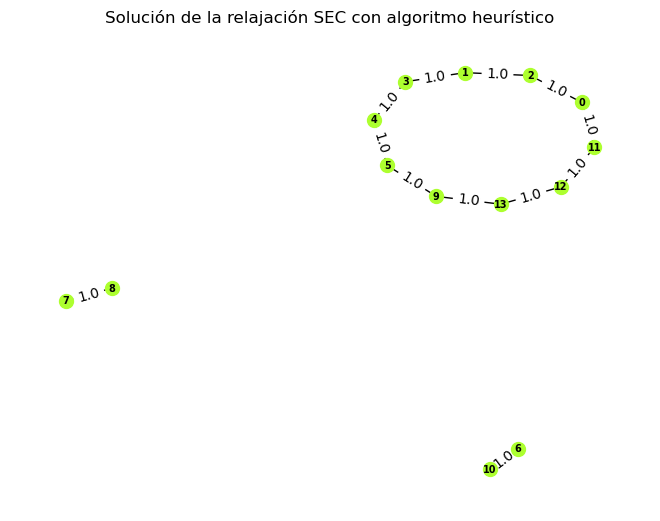

In [33]:
weighted_graph = grafo(mat7)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight']>0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color="greenyellow", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación SEC con algoritmo heurístico")
plt.show()

El coste de esta solución es de $249$. Vemos que claramente la solución obtenida tiene tres subtours. Así, añadimos las SEC violadas por $W_7=\{6,10\}$, $W_8=\{8,7\}$, ya que no podemos hacer otra cosa con la solución que tenemos.

In [12]:
tour = [0,2,1,3,9,8,7,4,5,6,10,13,12,11,0]

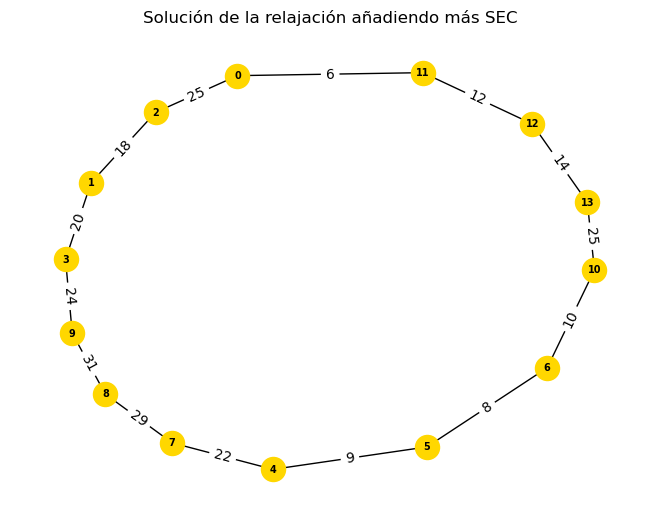

In [15]:
mat = new_matrix(bares_time,tour)

weighted_graph = grafo(mat)

# Subgrafo con peso >0
edges_to_keep = [(u, v) for u, v, d in weighted_graph.edges(data=True) if d['weight'] > 0]
subgraph = weighted_graph.edge_subgraph(edges_to_keep)

# Imprimimos subgrafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=300, node_color="gold", 
        font_size=7, font_color="black", font_weight="bold", arrowsize=10)
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
plt.title("Solución de la relajación añadiendo más SEC")
plt.show()

In [17]:
cost(bares_time,tour)

253

Así pues hemos vuelto a obtener la solución óptima! No obstante, podemos observar que las dos soluciones óptimas encontradas son diferentes! Es decir, son soluciones óptimas alternativas a nuestro problema. Las dos son soluciones fáctibles con coste mínimo pero los tours son diferentes.

In [34]:
print("Solución óptima anterior:", optim_tour, "\nSolución óptima encontrada ahora:", tour)

Solución óptima anterior: [0, 11, 12, 13, 9, 8, 7, 4, 5, 6, 10, 3, 1, 2, 0] 
Solución óptima encontrada ahora: [0, 2, 1, 3, 9, 8, 7, 4, 5, 6, 10, 13, 12, 11, 0]
